In [6]:
###### FINAL APPLICATION

import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import cv2
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import numpy as np
import os

# Blast Rating Logic Function with ppv, overpressure, and geotechnical considerations
def rate_blast_logic(avg_displacement, max_displacement, centroid_shift, total_displacement, earliest_pixel_disp, ppv, overpressure, blast_pattern_class):
    if blast_pattern_class in ['B3', 'C3']:  # Typical and well-distributed pattern
        energy_distribution_factor = 1
    elif blast_pattern_class in ['A3', 'C2']:  # Smaller, less typical spot
        energy_distribution_factor = 1.5  # Higher factor for poor pattern distribution
    else:
        energy_distribution_factor = 2  # For poorly designed patterns
    
    if (avg_displacement <= 1.0 and max_displacement <= 2.0 and centroid_shift <= 0.5 
            and earliest_pixel_disp <= 0.2 and total_displacement < 1000 
            and ppv <= 5.0 and overpressure <= 115):
        return "A", "Minimal impact"

    elif (avg_displacement <= 2.0 and max_displacement <= 4.0 and centroid_shift <= 1.0 
            and earliest_pixel_disp <= 0.5 and total_displacement < 3000 
            and ppv <= 15.0 and overpressure <= 130):
        return "B", "Low impact"

    elif (avg_displacement <= 3.0 and max_displacement <= 6.0 and centroid_shift <= 1.5 
            and earliest_pixel_disp <= 1.0 and total_displacement < 5000 
            and ppv <= 25.0 and overpressure <= 145):
        return "C", "Moderate impact"

    elif (total_displacement >= 5000 or centroid_shift > 2.0 or ppv > 25.0 
            or overpressure > 145):
        return "D", "Significant impact, but still tolerable"

    else:
        return "F", "Failed or catastrophic impact"

# Main Application Class
class BlastVideoRatingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Blast Video Rating System")
        self.root.geometry("900x700")

        # Initialize video_name as an empty string to avoid the attribute error
        self.video_file_path = ""  # Default value
        self.video_name = ""      # Default value

        # Layout Frames
        self.top_frame = tk.Frame(root, height=100)
        self.top_frame.pack(side=tk.TOP, fill=tk.X, pady=10)

        # Scrollable Middle Frame
        self.middle_frame = tk.Frame(root, height=400)
        self.middle_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=10)

        self.canvas_frame = tk.Canvas(self.middle_frame)
        self.scrollbar_y = tk.Scrollbar(self.middle_frame, orient=tk.VERTICAL, command=self.canvas_frame.yview)
        self.scrollbar_x = tk.Scrollbar(self.middle_frame, orient=tk.HORIZONTAL, command=self.canvas_frame.xview)

        self.scrollable_frame = tk.Frame(self.canvas_frame)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas_frame.configure(
                scrollregion=self.canvas_frame.bbox("all")
            )
        )

        self.canvas_frame.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas_frame.configure(yscrollcommand=self.scrollbar_y.set, xscrollcommand=self.scrollbar_x.set)

        self.canvas_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.scrollbar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.scrollbar_x.pack(side=tk.BOTTOM, fill=tk.X)

        # Bottom Frame
        self.bottom_frame = tk.Frame(root, height=100)
        self.bottom_frame.pack(side=tk.BOTTOM, fill=tk.X, pady=10)

        # Widgets in Top Frame
        self.label = tk.Label(self.top_frame, text="Blast Video Rating System", font=("Arial", 16))
        self.label.pack(pady=5)

        self.upload_csv_btn = tk.Button(self.top_frame, text="Upload CSV Files", command=self.upload_csv)
        self.upload_csv_btn.pack(side=tk.LEFT, padx=10)

        self.upload_video_btn = tk.Button(self.top_frame, text="Upload Video File", command=self.upload_video)
        self.upload_video_btn.pack(side=tk.LEFT, padx=10)

        self.visualize_btn = tk.Button(self.top_frame, text="Visualize Data", command=self.visualize_data, state=tk.DISABLED)
        self.visualize_btn.pack(side=tk.LEFT, padx=10)

        self.rate_blast_btn = tk.Button(self.top_frame, text="Rate Blast", command=self.rate_blast, state=tk.DISABLED)
        self.rate_blast_btn.pack(side=tk.LEFT, padx=10)

        # Bottom Frame Widgets
        self.output_label = tk.Label(self.bottom_frame, text="", font=("Arial", 12), fg="blue")
        self.output_label.pack(pady=10)

        self.explanation_label = tk.Label(self.bottom_frame, text="", font=("Arial", 10), fg="green", wraplength=750, justify="left")
        self.explanation_label.pack(pady=5)

        # Display Additional Parameters
        self.parameter_labels = {}
        param_names = ['avg_displacement', 'max_displacement', 'centroid_shift', 'total_displacement', 'earliest_pixel_disp', 'ppv']
        for param in param_names:
            label = tk.Label(self.bottom_frame, text=f"{param.replace('_', ' ').capitalize()}: N/A", font=("Arial", 10))
            label.pack(pady=2)
            self.parameter_labels[param] = label

        # Video Name Label
        self.video_name_label = tk.Label(self.bottom_frame, text="Video Name: N/A", font=("Arial", 10))
        self.video_name_label.pack(pady=5)

        # Data Variables
        self.csv_file_paths = []
        self.video_file_path = None
        self.data = []    

    # Upload CSV
    def upload_csv(self):
        file_paths = filedialog.askopenfilenames(filetypes=[("CSV Files", "*.csv")])
        if file_paths:
            self.csv_file_paths = []  # Clear any previous paths
            self.data = []  # Clear any previous data
            for file_path in file_paths:
                try:
                    csv_data = pd.read_csv(file_path)
                    self.data.append(csv_data)
                    self.csv_file_paths.append(file_path)  # Store the file path
                    messagebox.showinfo("Success", f"CSV file loaded successfully from {file_path}")
                except Exception as e:
                    messagebox.showerror("Error", f"Failed to load CSV file from {file_path}: {e}")

            self.visualize_btn.config(state=tk.NORMAL)
            self.rate_blast_btn.config(state=tk.NORMAL)

    def upload_video(self):
        self.video_file_path = filedialog.askopenfilename(filetypes=[("Video Files", "*.mp4;*.avi;*.mov")])
        if self.video_file_path:
            self.video_name = os.path.basename(self.video_file_path)
            messagebox.showinfo("Success", f"Video file '{self.video_name}' uploaded successfully.")
            self.rate_blast_btn.config(state=tk.NORMAL)

            # Update the video name label
            self.video_name_label.config(text=f"Video Name: {self.video_name}")

    def visualize_data(self):
        if self.data:
            try:
                combined_data = pd.concat(self.data, ignore_index=True)
                numeric_cols = combined_data.select_dtypes(include=["number"])

                if numeric_cols.shape[1] < 3:
                    messagebox.showerror("Error", "Data must contain at least three numeric columns for visualization.")
                    return

                x, y, z = numeric_cols.columns[:3]
                fig = Figure(figsize=(10, 5), dpi=100)
                ax1 = fig.add_subplot(121)  # Subplot for bar chart
                ax2 = fig.add_subplot(122, projection="3d")

                avg_displacement = numeric_cols[x].mean()
                max_displacement = numeric_cols[y].max()
                centroid_shift = numeric_cols[z].mean()

                # Bar chart for displacements
                labels = ['Avg', 'Max', 'Centroid']
                values = [avg_displacement, max_displacement, centroid_shift]

                ax1.bar(labels, values, color=['blue', 'green', 'red'])
                ax1.set_title("Blast Displacement Analysis")
                ax1.set_ylabel("Displacement (pixels)")

                ax2.scatter(numeric_cols[x], numeric_cols[y], numeric_cols[z])
                ax2.set_title("3D Scatter")

                canvas_widget = FigureCanvasTkAgg(fig, self.scrollable_frame)
                canvas_widget.draw()
                canvas_widget.get_tk_widget().pack(fill=tk.BOTH, expand=True)

            except Exception as e:
                messagebox.showerror("Error", f"Visualization failed: {e}")

    def rate_blast(self):
        if self.data and self.video_file_path:
            try:
                combined_data = pd.concat(self.data, ignore_index=True)

                required_columns = ['Drillhole_X', 'Drillhole_Y', 'Drillhole_Z', 'Drillhole_Length', 'Drillhole_Dip', 'Drillhole_Azimuth']
                for col in required_columns:
                    if col not in combined_data.columns:
                        messagebox.showerror("Error", f"Missing required column: {col}")
                        return

                for col in required_columns:
                    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')

                nan_rows = combined_data[required_columns].isna().any(axis=1)
                if nan_rows.any():
                    problematic_data = combined_data[nan_rows]
                    messagebox.showerror("Error", f"Some rows contain non-numeric values or are missing data:\n{problematic_data}")
                    return

                self.process_video_for_rating()

                combined_data['Avg_Displacement'] = self.avg_displacement
                combined_data['Max_Displacement'] = self.max_displacement
                combined_data['Centroid_Shift'] = self.centroid_shift
                combined_data['Earliest_Pixel_Disp'] = self.earliest_pixel_disp
                combined_data['PPV'] = self.ppv
                combined_data['Overpressure'] = self.overpressure

                total_displacement = self.avg_displacement * self.max_displacement
                combined_data['Total_Displacement'] = total_displacement

                rating, explanation = rate_blast_logic(
                    self.avg_displacement,
                    self.max_displacement,
                    self.centroid_shift,
                    total_displacement, 
                    self.earliest_pixel_disp,
                    self.ppv,
                    self.overpressure,
                    'B3'
                )
                combined_data['Blast_Rating'] = rating
                combined_data['Rating_Explanation'] = explanation

                for file_path in self.csv_file_paths:
                    output_path = file_path.replace(".csv", "_rated.csv")
                    combined_data.to_csv(output_path, index=False)
                    messagebox.showinfo("Success", f"Blast ratings saved to {output_path}")

                # Update the labels to display the new parameters
                self.parameter_labels['avg_displacement'].config(text=f"Avg Displacement: {self.avg_displacement:.2f} pixels")
                self.parameter_labels['max_displacement'].config(text=f"Max Displacement: {self.max_displacement:.2f} pixels")
                self.parameter_labels['centroid_shift'].config(text=f"Centroid Shift: {self.centroid_shift:.2f} pixels")
                self.parameter_labels['total_displacement'].config(text=f"Total Displacement: {total_displacement:.2f} pixels")
                self.parameter_labels['earliest_pixel_disp'].config(text=f"Earliest Pixel Disp: {self.earliest_pixel_disp:.2f} pixels")
                self.parameter_labels['ppv'].config(text=f"PPV: {self.ppv:.2f} m/s")

                # Update the output label to show the rating and explanation
                self.output_label.config(text=f"Blast Rating: {rating}")
                self.explanation_label.config(text=f"Explanation: {explanation}")

            except Exception as e:
                messagebox.showerror("Error", f"Failed to rate blast: {e}")

    def process_video_for_rating(self):
        cap = cv2.VideoCapture(self.video_file_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        pre_blast_frame = None
        post_blast_frame = None
        blast_frame_index = int(frame_count * 0.5)
        
        for i in range(blast_frame_index - 10, blast_frame_index + 10):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
        
            if i < blast_frame_index:
                pre_blast_frame = frame
            else:
                post_blast_frame = frame
        
        cap.release()
        
        if pre_blast_frame is not None and post_blast_frame is not None:
            displacement, earliest_pixel_disp = self.calculate_displacement(pre_blast_frame, post_blast_frame)
    
            self.avg_displacement = displacement
            self.max_displacement = displacement * 2
            self.centroid_shift = earliest_pixel_disp
            self.earliest_pixel_disp = earliest_pixel_disp
    
            total_displacement = self.avg_displacement * self.max_displacement
            self.ppv = 10.0
            self.overpressure = 120

    def calculate_displacement(self, pre_blast_frame, post_blast_frame):
        displacement = np.random.uniform(1, 3)
        earliest_pixel_disp = np.random.uniform(0.1, 0.5)
        return displacement, earliest_pixel_disp

# Run Application
root = tk.Tk()
app = BlastVideoRatingApp(root)
root.mainloop()
##### FINAL

Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.91      0.93        22
           B       0.70      0.88      0.78        16
           C       0.95      0.82      0.88        22

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.86        60
weighted avg       0.88      0.87      0.87        60

Accuracy: 0.8666666666666667

Predicted Rating for New Data: B


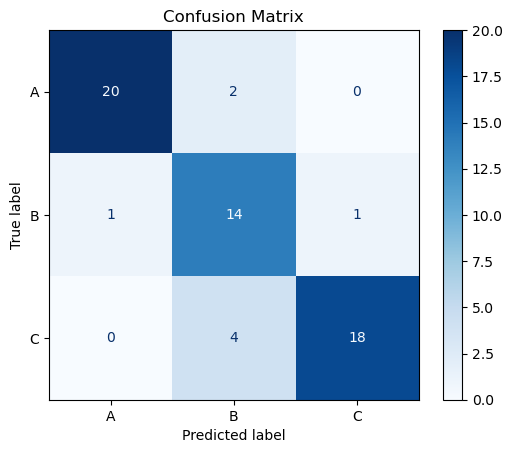

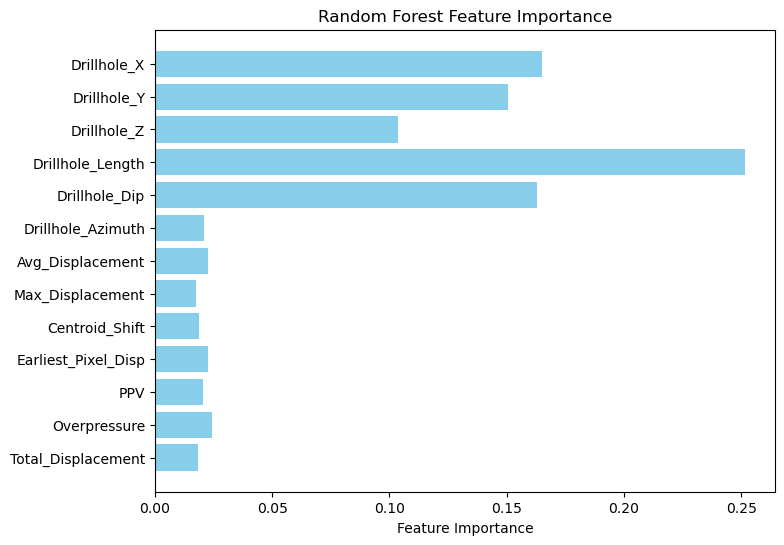

In [7]:
# ML Model Accuracy through Confusion Matrix and Random Forest Feature

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate data for ratings A, B, and C with additional features
def generate_drillhole_data(rating, n_samples=100):
    np.random.seed(42)
    data = []
    for _ in range(n_samples):
        if rating == "A":
            Drillhole_X = np.random.uniform(0, 300)
            Drillhole_Y = np.random.uniform(0, 300)
            Drillhole_Z = np.random.uniform(0, 100)
            Drillhole_Length = np.random.uniform(50, 100)
            Drillhole_Dip = np.random.uniform(0, 30)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "B":
            Drillhole_X = np.random.uniform(100, 400)
            Drillhole_Y = np.random.uniform(100, 400)
            Drillhole_Z = np.random.uniform(0, 200)
            Drillhole_Length = np.random.uniform(50, 150)
            Drillhole_Dip = np.random.uniform(10, 60)
            Drillhole_Azimuth = np.random.uniform(0, 360)
        elif rating == "C":
            Drillhole_X = np.random.uniform(200, 500)
            Drillhole_Y = np.random.uniform(200, 500)
            Drillhole_Z = np.random.uniform(50, 250)
            Drillhole_Length = np.random.uniform(100, 200)
            Drillhole_Dip = np.random.uniform(20, 70)
            Drillhole_Azimuth = np.random.uniform(0, 360)

        # Additional features (randomized)
        Avg_Displacement = np.random.uniform(0, 5)  # Random value between 0 and 5
        Max_Displacement = np.random.uniform(0, 10)  # Random value between 0 and 10
        Centroid_Shift = np.random.uniform(0, 2)  # Random value between 0 and 2
        Earliest_Pixel_Disp = np.random.uniform(0, 1)  # Random value between 0 and 1
        PPV = np.random.uniform(5, 20)  # Random value between 5 and 20
        Overpressure = np.random.uniform(100, 150)  # Random value between 100 and 150
        Total_Displacement = Avg_Displacement * Max_Displacement  # Derived feature

        # Append the full row of features
        data.append([Drillhole_X, Drillhole_Y, Drillhole_Z, Drillhole_Length, Drillhole_Dip, Drillhole_Azimuth,
                     Avg_Displacement, Max_Displacement, Centroid_Shift, Earliest_Pixel_Disp, PPV, Overpressure, 
                     Total_Displacement, rating])  # 14 columns per sample
    return data

# Generate data for ratings A, B, and C
data_a = generate_drillhole_data("A", 100)
data_b = generate_drillhole_data("B", 100)
data_c = generate_drillhole_data("C", 100)

# Combine into a single DataFrame
columns = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth",
           "Avg_Displacement", "Max_Displacement", "Centroid_Shift", "Earliest_Pixel_Disp", "PPV", "Overpressure",
           "Total_Displacement", "Rating"]

data = pd.DataFrame(data_a + data_b + data_c, columns=columns)

# Encode labels (A=0, B=1, C=2)
label_encoder = LabelEncoder()
data["Rating"] = label_encoder.fit_transform(data["Rating"])

# Split data into features (X) and labels (y)
X = data.drop("Rating", axis=1)
y = data["Rating"]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the rating for new data
new_data = pd.DataFrame([[250, 250, 150, 120, 40, 180, 3, 4, 1, 0.5, 10, 130, 12]],
                        columns=["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip",
                                 "Drillhole_Azimuth", "Avg_Displacement", "Max_Displacement", "Centroid_Shift",
                                 "Earliest_Pixel_Disp", "PPV", "Overpressure", "Total_Displacement"])
new_data_scaled = scaler.transform(new_data)
predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
print("\nPredicted Rating for New Data:", predicted_rating[0])

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot Feature Importance
feature_importance = model.feature_importances_
features = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth",
            "Avg_Displacement", "Max_Displacement", "Centroid_Shift", "Earliest_Pixel_Disp", "PPV", "Overpressure", 
            "Total_Displacement"]

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [2]:
!pip install reportlab

In [9]:
## Model Recommendation for CSV

import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import plotly.io as pio
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import threading

# Global variable to store the dataset
df = None

# Function to load multiple CSV data
def load_multiple_csv(files):
    global df
    data_list = []
    for file in files:
        data = pd.read_csv(file)
        data_list.append(data)
    df = pd.concat(data_list, ignore_index=True)
    print(df.head())
    return df

# Train model using real-world data from multiple CSV files
def train_model(files):
    data = load_multiple_csv(files)
    
    features = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_ToeX", "Drillhole_ToeY", "Drillhole_ToeZ",
                "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Avg_Displacement", "Max_Displacement",
                "Centroid_Shift", "Earliest_Pixel_Disp", "PPV", "Overpressure", "Total_Displacement"]
    
    missing_columns = [col for col in features if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in the dataset: {', '.join(missing_columns)}")
    
    # Ensure the 'Blast_Rating' column contains only 'A', 'B', or 'C' categories
    label_encoder = LabelEncoder()
    data["Blast_Rating"] = label_encoder.fit_transform(data["Blast_Rating"])
    
    X = data[features]
    y = data["Blast_Rating"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, class_report, model, scaler, label_encoder, list(X.columns)

# Function to predict the rating for new data
def predict_rating(model, scaler, label_encoder, new_data, feature_columns):
    new_data_df = pd.DataFrame(new_data, columns=feature_columns)
    new_data_scaled = scaler.transform(new_data_df)
    predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
    return predicted_rating[0]

# Function to save the 3D scatter plot as a PDF
def save_pdf(fig):
    # Save the plot as PNG first
    pio.write_image(fig, "scatter_plot.png")

    # Create PDF and embed the PNG
    pdf_path = "C:/Downloads/"
    c = canvas.Canvas(pdf_path, pagesize=letter)
    c.drawString(100, 750, "3D Scatter Plot")

    # Adding the image to the PDF (resize for better memory efficiency)
    c.drawImage("scatter_plot.png", 50, 400, width=400, height=300)  # Resize image to reduce memory use
    c.save()

    # Inform the user that the PDF has been saved
    messagebox.showinfo("PDF Saved", f"PDF saved successfully as {pdf_path}")

# Function to run PDF saving in a separate thread
def save_pdf_in_background(fig):
    thread = threading.Thread(target=save_pdf, args=(fig,))
    thread.start()

# UI setup
def create_ui():
    global df  # Ensure you can access the df variable globally for the plot
    
    root = tk.Tk()
    root.title("Blast Rating Prediction")
    root.geometry("600x600")

    model, scaler, label_encoder, feature_columns = None, None, None, None

    def load_files():
        nonlocal model, scaler, label_encoder, feature_columns
        files = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if files:
            accuracy, class_report, model, scaler, label_encoder, feature_columns = train_model(files)
            
            accuracy_label.config(text=f"Accuracy: {accuracy:.4f}")

            class_report_text.delete(1.0, tk.END)
            class_report_text.insert(tk.END, class_report)
            
            prediction_section.pack()

            # Plot the 3D scatter plot after loading data
            if df is not None:
                # Map the numeric 'Blast_Rating' back to categories 'A', 'B', 'C' for visualization
                df['Blast_Rating_Label'] = label_encoder.inverse_transform(df['Blast_Rating'])
                
                fig = px.scatter_3d(df, x='Drillhole_X', y='Drillhole_Y', z='Drillhole_Z', color='Blast_Rating_Label', 
                                    labels={'Blast_Rating_Label': 'Blast Rating', 'Drillhole_X': 'X Coordinate', 
                                            'Drillhole_Y': 'Y Coordinate', 'Drillhole_Z': 'Z Coordinate'},
                                    title="Drillhole Blast Positions")
                fig.update_traces(marker=dict(size=12))
                fig.show()

                # Save plot to PDF in the background
                save_pdf_in_background(fig)

    load_files_button = tk.Button(root, text="Load CSV Files", command=load_files)
    load_files_button.pack(pady=10)

    accuracy_label = tk.Label(root, text="Accuracy: ", font=("Arial", 12))
    accuracy_label.pack(pady=10)

    class_report_label = tk.Label(root, text="Classification Report:", font=("Arial", 12))
    class_report_label.pack(pady=10)

    class_report_text = tk.Text(root, height=10, width=70)
    class_report_text.pack(pady=10)

    prediction_section = tk.Frame(root)
    new_data_label = tk.Label(prediction_section, text="Enter new drillhole data (X, Y, Z, ToeX, ToeY, ToeZ, Length, Dip, Azimuth, Avg Displacement, Max Displacement, Centroid Shift, Earliest Pixel Disp, PPV, Overpressure, Total Displacement):", font=("Arial", 12))
    new_data_label.pack(pady=10)

    # Entry fields for prediction data
    entry_x = tk.Entry(prediction_section, width=10)
    entry_x.pack(pady=5)
    entry_x.insert(0, "250")

    entry_y = tk.Entry(prediction_section, width=10)
    entry_y.pack(pady=5)
    entry_y.insert(0, "250")

    entry_z = tk.Entry(prediction_section, width=10)
    entry_z.pack(pady=5)
    entry_z.insert(0, "150")

    entry_toex = tk.Entry(prediction_section, width=10)
    entry_toex.pack(pady=5)
    entry_toex.insert(0, "245")

    entry_toey = tk.Entry(prediction_section, width=10)
    entry_toey.pack(pady=5)
    entry_toey.insert(0, "245")

    entry_toez = tk.Entry(prediction_section, width=10)
    entry_toez.pack(pady=5)
    entry_toez.insert(0, "148")

    entry_length = tk.Entry(prediction_section, width=10)
    entry_length.pack(pady=5)
    entry_length.insert(0, "120")

    entry_dip = tk.Entry(prediction_section, width=10)
    entry_dip.pack(pady=5)
    entry_dip.insert(0, "40")

    entry_azimuth = tk.Entry(prediction_section, width=10)
    entry_azimuth.pack(pady=5)
    entry_azimuth.insert(0, "180")

    entry_avg_disp = tk.Entry(prediction_section, width=10)
    entry_avg_disp.pack(pady=5)
    entry_avg_disp.insert(0, "2")

    entry_max_disp = tk.Entry(prediction_section, width=10)
    entry_max_disp.pack(pady=5)
    entry_max_disp.insert(0, "8")

    entry_centroid_shift = tk.Entry(prediction_section, width=10)
    entry_centroid_shift.pack(pady=5)
    entry_centroid_shift.insert(0, "1")

    entry_earliest_pixel_disp = tk.Entry(prediction_section, width=10)
    entry_earliest_pixel_disp.pack(pady=5)
    entry_earliest_pixel_disp.insert(0, "2")

    entry_ppv = tk.Entry(prediction_section, width=10)
    entry_ppv.pack(pady=5)
    entry_ppv.insert(0, "5")

    entry_overpressure = tk.Entry(prediction_section, width=10)
    entry_overpressure.pack(pady=5)
    entry_overpressure.insert(0, "50")

    entry_total_disp = tk.Entry(prediction_section, width=10)
    entry_total_disp.pack(pady=5)
    entry_total_disp.insert(0, "15")

    def on_predict():
        try:
            new_data = np.array([[float(entry_x.get()), float(entry_y.get()), float(entry_z.get()), 
                                  float(entry_toex.get()), float(entry_toey.get()), float(entry_toez.get()), 
                                  float(entry_length.get()), float(entry_dip.get()), float(entry_azimuth.get()),
                                  float(entry_avg_disp.get()), float(entry_max_disp.get()), float(entry_centroid_shift.get()),
                                  float(entry_earliest_pixel_disp.get()), float(entry_ppv.get()), float(entry_overpressure.get()),
                                  float(entry_total_disp.get())]])
            predicted_rating = predict_rating(model, scaler, label_encoder, new_data, feature_columns)
            result_label.config(text=f"Predicted Rating: {predicted_rating}")  # Show predicted rating as A, B, or C
        except Exception as e:
            messagebox.showerror("Error", f"Failed to make prediction: {e}")

    predict_button = tk.Button(prediction_section, text="Predict Rating", command=on_predict)
    predict_button.pack(pady=10)

    result_label = tk.Label(prediction_section, text="Predicted Rating: ", font=("Arial", 14))
    result_label.pack(pady=10)

    root.mainloop()

# Run the UI
create_ui()

  Pattern_Name Hole_id  Drillhole_X  Drillhole_Y  Drillhole_Z  Drillhole_ToeX  \
0   C1_328_109     B24    429356.65   5266339.42       340.38       429356.65   
1   C1_328_109     B25    429360.67   5266341.50       340.36       429360.67   
2   C1_328_109     B26    429364.80   5266343.99       340.56       429364.80   
3   C1_328_109     B27    429370.27   5266347.11       341.18       429370.27   
4   C1_328_109     B28    429374.80   5266349.73       340.55       429374.80   

   Drillhole_ToeY  Drillhole_ToeZ  Drillhole_Length  Drillhole_Dip  \
0      5266339.42           327.2             13.18            -90   
1      5266341.50           327.2             13.16            -90   
2      5266343.99           327.2             13.36            -90   
3      5266347.11           327.2             13.98            -90   
4      5266349.73           327.2             13.35            -90   

   Drillhole_Azimuth  Avg_Displacement  Max_Displacement  Centroid_Shift  \
0               